In [7]:
import os
import pandas as pd
import numpy as np
import sys
import librosa
import re
import glob
import librosa.display
import seaborn as sns
from IPython.display import Audio

import matplotlib.pyplot as plt

import plotly.express as px
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [8]:
def extract_features(data, sample_rate):
 # Extract features
 zcr = librosa.feature.zero_crossing_rate(y=data)
 mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
 rms = librosa.feature.rms(y=data)
 mel = librosa.feature.melspectrogram(y=data, sr=sample_rate)
 # Average across columns (axis=1)
 zcr_avg = np.mean(zcr, axis=1)
 mfcc_avg = np.mean(mfcc, axis=1)
 rms_avg = np.mean(rms, axis=1)
 mel_avg = np.mean(mel, axis=1)

 # Concatenate into single row
 features = np.concatenate([zcr_avg, mfcc_avg, rms_avg, mel_avg])
 # Convert to dataframe and transpose it
 df = pd.DataFrame(features).T
 return df

In [9]:
def train_random_forest(frames):
 print(frames)
 # Use pandas iloc fn to extract the first 150 columns as features.
 # Careful about how the indexing works (cols start from 0)
 X = frames.iloc[: , 0:150]
 # Use pandas iloc function to extract the 151st column as the prediction target.
 # Again, careful about how indexing works (col numbers start from 0)
 y = frames.iloc[: , 150]
 # Split data
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 Emotion_rf = RandomForestClassifier()
 Emotion_rf_model = Emotion_rf.fit(X_train, y_train)
 Emotion_rf_pred = Emotion_rf_model.predict(X_test)
 print(classification_report(y_test, Emotion_rf_pred))
 # Evaluate on test set
 acc = Emotion_rf_model.score(X_test, y_test)
 Emotion_rf_cm = confusion_matrix(y_test, Emotion_rf_pred)
 print(Emotion_rf_cm)
 return Emotion_rf_model, Emotion_rf_cm, acc, X_test, y_test

In [10]:
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

        feat_0      feat_1     feat_2     feat_3     feat_4     feat_5  \
0     0.115105 -421.487396  81.257996 -29.792982  23.297741  -1.931755   
1     0.165769 -422.426727  45.477676 -49.539612   9.665775 -26.721834   
2     0.118894 -394.667969  68.593277 -33.710220  26.729691  -6.313067   
3     0.146355 -452.100342  34.897243 -34.124691   9.025678 -20.783140   
4     0.101433 -477.273315  90.715858 -20.335976  31.356554  -0.887785   
...        ...         ...        ...        ...        ...        ...   
1007  0.150475 -268.571289  39.477119 -27.952879  -6.971773 -22.774773   
1008  0.136275 -305.651733  75.087738 -31.771931  10.891046   4.713885   
1009  0.149717 -358.844971  24.818798 -21.207952  -3.233071  -8.353400   
1010  0.121251 -309.315765  73.635429 -29.995825  17.066984   9.771923   
1011  0.181916 -320.394501  25.034025  -9.739794   0.121781 -25.635696   

         feat_6     feat_7     feat_8     feat_9  ...  feat_141  feat_142  \
0     -5.580793 -24.973911 -14.229

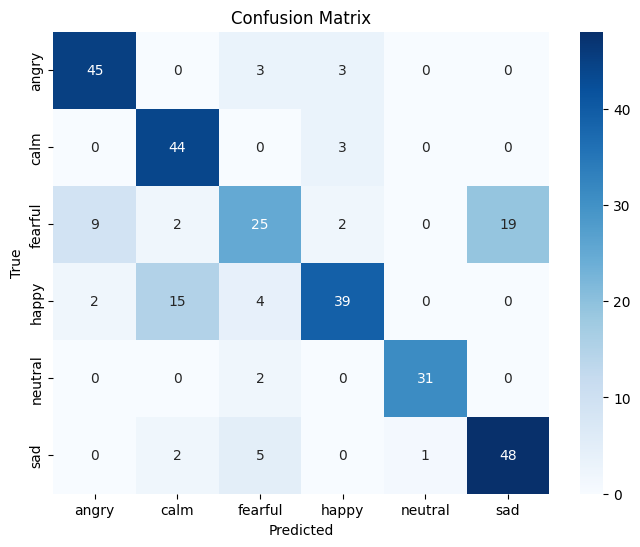

Accuracy: 0.76
              precision    recall  f1-score   support

       angry       0.80      0.88      0.84        51
        calm       0.70      0.94      0.80        47
     fearful       0.64      0.44      0.52        57
       happy       0.83      0.65      0.73        60
     neutral       0.97      0.94      0.95        33
         sad       0.72      0.86      0.78        56

    accuracy                           0.76       304
   macro avg       0.78      0.78      0.77       304
weighted avg       0.76      0.76      0.75       304



In [11]:
filenames = glob.glob("data\\all\\*.wav")
frames = pd.DataFrame()
for filename in filenames:
 # Extract the emotion label
 fsplit = filename.split('-')
 emotion = emotion_mapping[fsplit[2]]
 # duration and offset are used to take care of the no audio in start and the ending of each aud
 data, sample_rate = librosa.load(filename, duration=2.0, offset=0.9)
 feature_df = extract_features(data, sample_rate)
 emotion_df = pd.DataFrame([emotion])
 # Assuming feature_df only has one row, you can directly concatenate along the columns
 combined_df = pd.concat([feature_df, emotion_df], axis=1)
 frames = pd.concat([frames, combined_df], ignore_index=True)

#Create column names
col_names = [f'feat_{i}' for i in range(150)] + ['label']
frames.columns = col_names
Emotion_rf_model, Emotion_rf_cm, acc, X_test, y_test = train_random_forest(frames)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(Emotion_rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=Emotion_rf_model.classes_, yticklabels=Emotion_rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f'Accuracy: {acc:.2f}')

# Print classification report
Emotion_rf_pred = Emotion_rf_model.predict(X_test)
print(classification_report(y_test, Emotion_rf_pred))